In [1]:
%ls

figures/  input/  output/  run protien-sol.ipynb  software/


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

## preprocessing

In [3]:
foldx_dir = '/home/hew/python/genhance/foldx/'
train_data_path = foldx_dir + 'new_train_data/train_new_all_data.pkl'
protein_sol_dir = '/home/hew/python/genhance/protein_sol/'
script_dir = protein_sol_dir + 'software/'
script_path = protein_sol_dir + 'software/multiple_prediction_wrapper_export.sh'
eval_input_dir = protein_sol_dir + 'input/'
eval_output_dir = protein_sol_dir + 'output/'
script_dir, script_path

('/home/hew/python/genhance/protein_sol/software/',
 '/home/hew/python/genhance/protein_sol/software/multiple_prediction_wrapper_export.sh')

In [4]:
input_list = list(os.walk(eval_input_dir))[0][1][1:]
input_list

['congen9_new_solubility_6_layer_gens_step_final_[12.0]_[1.0]',
 'congen9_new_solubility_6_layer_gens_step_final_[4.0]_[1.0]',
 'congen9_new_solubility_6_layer_gens_step_final_[8.0]_[1.0]',
 'congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]',
 'congen10_new_ddG_solubility_6_layer_gens_step_final_[-40.0]_[1.0]_[1.0]',
 'congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]',
 'congen8_new_ddG_260000_[-40.0]_[1.0]']

In [5]:
input_index = -1
output_dir_suffix = ''
# output_dir_suffix = '_Emin'
property_name = 'ddG'
# property_name = 'solubility'
# property_name = 'ddG_solubility_avg'
# topk = 100
topk = 1000

input_dir = f'{eval_input_dir}/{input_list[input_index]}/'
output_dir = f'{eval_output_dir}/{input_list[input_index]}{output_dir_suffix}/'
topk_tsv = input_dir + f'{property_name}_top{topk}.tsv'
fasta_path = f'{eval_output_dir}/{input_list[input_index]}{output_dir_suffix}/{property_name}_top{topk}.fasta'

input_dir, output_dir, topk_tsv, fasta_path

('/home/hew/python/genhance/protein_sol/input//congen8_new_ddG_260000_[-40.0]_[1.0]/',
 '/home/hew/python/genhance/protein_sol/output//congen8_new_ddG_260000_[-40.0]_[1.0]/',
 '/home/hew/python/genhance/protein_sol/input//congen8_new_ddG_260000_[-40.0]_[1.0]/ddG_top1000.tsv',
 '/home/hew/python/genhance/protein_sol/output//congen8_new_ddG_260000_[-40.0]_[1.0]/ddG_top1000.fasta')

In [6]:
os.makedirs(output_dir, exist_ok=True)

In [7]:
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
WT_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

## train data

In [8]:
train_data = open(train_data_path, 'rb')
train_data = pickle.load(train_data)

In [9]:
train_data

,PDB,Chain,Start_index,WT_seq,MT_seq,solubility,ddG,ddG_std,ddG_rank,solubility_rank,avg_rank
0,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.764,0.487536,0.173732,27073.0,114868.5,70970.75
1,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.701,1.671400,0.154878,51857.0,226709.0,139283.00
2,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.769,6.211590,0.087345,150915.0,68731.0,109823.00
3,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.807,9.822730,2.028930,201957.0,12266.5,107111.75
4,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKPFLDKFNHEAEDLFYQHSLASWNYNTNITEENVQNMNN...,0.752,3.106590,0.163249,84850.5,168879.0,126864.75
...,...,...,...,...,...,...,...,...,...,...,...
249995,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQDSLASWNYNTNITEENVQNMNN...,0.781,2.569060,0.042348,72549.0,43637.0,58093.00
249996,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMFN...,0.764,3.736110,0.500392,99288.0,114868.5,107078.25
249997,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLDYQSSLASWNYNTNITEENVQNMNN...,0.781,1.555830,0.024263,49188.0,43637.0,46412.50
249998,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,YTIEEQAKTFLDKFNHEAEDMFYVSSLASWNYNTNITEENVQNMNN...,0.824,5.724200,0.292841,141810.0,5272.5,73541.25


In [10]:
train_data[0.85 < train_data.solubility].sort_values(by='solubility', ascending=False)

,PDB,Chain,Start_index,WT_seq,MT_seq,solubility,ddG,ddG_std,ddG_rank,solubility_rank,avg_rank
130420,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SNIEEQAKTKLDKFNHEAEDVFYQSVLASANYNTNITEENVQNMNN...,0.933,13.71210,1.056890,229532.0,1.0,114766.50
130161,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTKLDEGNHEAEDLFYQSSLASWNQNTNITEENVQNMND...,0.911,18.29540,0.704757,242367.0,3.0,121185.00
207791,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTRLDKFNHEAEDPFYQSSLASDNDNTNITEENVQNMMN...,0.911,22.75710,0.691252,246835.0,3.0,123419.00
134240,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEEQAKTFADKFNHEAEDLMEQSSLASWNYNTNITEENVQNMNN...,0.911,12.77370,0.785983,224758.0,3.0,112380.50
231850,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKENHEAEDDTYQSSLASWNYNTNITEENVQNMNN...,0.899,21.01820,0.785301,245581.0,5.0,122793.00
...,...,...,...,...,...,...,...,...,...,...,...
32796,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHVAEDVDYQSSLASWNENTNITEENVENMNN...,0.858,8.16023,0.289397,182113.0,116.0,91114.50
214858,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTMLDKFNHEAEDLFYQSSLAIVNYNTNITEENVQNMNN...,0.853,13.25700,0.507607,227406.0,118.5,113762.25
101984,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEVQAKTFLDKFNHEAEDLEHQSSLASQNYNTNITEENVANLNN...,0.853,14.84700,0.337864,234132.0,118.5,117125.25
183101,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTKLDKFNHEAEDLFIQSSLASWNYNTNITEENVQNMNN...,0.853,14.16780,1.027770,231512.0,118.5,115815.25


In [11]:
train_data.sort_values(by='avg_rank', ascending=True)

,PDB,Chain,Start_index,WT_seq,MT_seq,solubility,ddG,ddG_std,ddG_rank,solubility_rank,avg_rank
130013,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKIFLDKFNHEAEDRFYQSSLASYNYNTNITEENVQNMNN...,0.825,-2.04426,0.525979,1986.5,2605.5,2296.00
248705,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKYFLDYFNHEAEDMFYQSSLASWNYNTNITEENVQNMNN...,0.842,-1.45956,0.507725,4131.0,938.0,2534.50
248479,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLMSWNYNTNITEENVQNMNN...,0.842,-1.24724,0.146723,5355.0,938.0,3146.50
132207,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSMLANWNYNTNITEENVQNMNN...,0.824,-2.36012,0.930145,1323.0,5272.5,3297.75
10240,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.824,-2.21112,0.107442,1607.0,5272.5,3439.75
...,...,...,...,...,...,...,...,...,...,...,...
127042,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEHQYNTFLDKFNHIAADLFYQSSLASWNYNTNITEENKQNMNN...,0.585,28.69520,0.916621,249054.0,249417.0,249235.50
227483,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEWQAKTFLDKFNHEAEDRFYQRSLASWNYNTNITEENVQNGNN...,0.596,31.28520,2.129320,249443.0,249133.5,249288.25
186855,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEWQAKTFLDKFNHVFEDLFYQSSLASWNYNTNITEENVQNWNN...,0.566,33.08690,5.883440,249630.0,249712.0,249671.00
184192,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STISEQFKTFLKKRNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.566,37.23040,2.345030,249852.0,249712.0,249782.00


## gen data

In [12]:
topk_df = pd.read_csv(topk_tsv, sep='\t')
topk_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
0,STIEEMAKLFLDKFNHEAEDLFYQSLLASWNYNTNITEENMQNMNN...,-14.131250,NaN,STIEEQAKMFLDKFNHEAEDLFYQSSLASWNYNTNITEENTQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
1,STIEEMAKTFLEKFNHEAEDLFYQSSLALWSYNTNITEENVQNMNN...,-14.118752,NaN,STIEEQAKTFLMKFNHEAEDLFYQSSLASWFYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
2,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENMQNMNL...,-14.116454,NaN,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENMQNMNY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
3,STIEEQAKTFLEKFNHEAEDLFYQSSLAMWNYNTNITEENVQNMNN...,-14.113591,NaN,STIEEQAKTFLMKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
4,STIEEQAKTFLDKFNHEAEDLFYQSSLKAWNYNTNITEENVQNMNN...,-14.107990,NaN,STIEEQAKTFLDKFNHEAEDLFYQSSLYSWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
995,STIEEQAKTFLMKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNL...,-13.844300,NaN,STIEEQAKTFLMKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
996,SNIEEMAKTFLDKFNHEAEDLFYQSLLASWNYNTNITEENVQNMNM...,-13.844254,NaN,SNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
997,STIEEMALTFLYKFNHEAEDLFYQSMLAAWNYNTNITEENVQNMNN...,-13.844237,NaN,STIEEQAMTFLDKFNHEAEDLFYQSALASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
998,STIEEQAKTFLDKFNHEAEDLFYQSKLASWNMNTNITEENVQNMNK...,-13.844169,NaN,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNKNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


## format input fasta

In [13]:
def check_path(path, mkdir=True):
    '''
    检查路径所在文件夹是否存在, 如果路径不存在则自动新建
    :param path_fasta: 检查的文件路径
    :param mkdir: 是否自动创建文件夹
    :return: is_exist: bool
    '''
    dir = os.path.abspath(os.path.dirname(path)) if not os.path.isdir(path) else path
    # print('dir', dir)
    # print('os.path.isdir(path)', os.path.isdir(path))
    is_exist = os.path.exists(dir)
    # print('is_exist', is_exist)
    if mkdir and not is_exist:
        try:
            os.makedirs(dir)
            print(f'makedir: {dir}')
        except Exception:
            raise RuntimeError(f'The path does not exist, automatically mkdir {dir}: Failed')
    return is_exist

def write_fasta(path, seqs, custom_index=None, descriptions=None):
    '''
    调取biopython包输出fasta文件，写入成功则返回True，否则会报错
    :param path: 输出的目标路径
    :param seqs: 序列列表
    :param descriptions: 描述/标签列表
    :param custom_index: 自定义索引，如果为None则使用默认index，从0至len(seqs)-1
    :return: result: bool
    '''
    check_path(path)
    records = []
    if custom_index is None:
        custom_index = [str(i) for i in range(len(seqs))]
    for i in range(len(seqs)):
        if descriptions is None:
            seq_record = SeqRecord(Seq(seqs[i]), id=custom_index[i], description='')
        else:
            seq_record = SeqRecord(Seq(seqs[i]), id=custom_index[i], description=f'| {descriptions[i]}')
        records.append(seq_record)
    try:
        SeqIO.write(records, path, 'fasta')
    except Exception:
        raise RuntimeError('Failed to write fasta')
    return True

def read_fasta(path):
    '''
    调取biopython包读取fasta文件，返回fasta中每一条记录的序列以及对应的描述
    :param path: fasta文件路径
    :return: seqs: list, descriptions: list
    '''
    seqs = [str(fa.seq) for fa in SeqIO.parse(path, 'fasta')]
    descriptions = [fa.description for fa in SeqIO.parse(path, 'fasta')]
    return seqs, descriptions

In [14]:
write_fasta(fasta_path, topk_df.MT_seq)
fasta_path

'/home/hew/python/genhance/protein_sol/output//congen8_new_ddG_260000_[-40.0]_[1.0]/ddG_top1000.fasta'

## run prediction

In [25]:
command = f'cd {script_dir} && {script_path} {fasta_path}'
command

'cd /home/hew/python/genhance/protein_sol/software/ && /home/hew/python/genhance/protein_sol/software/multiple_prediction_wrapper_export.sh /home/hew/python/genhance/protein_sol/output//congen8_new_ddG_260000_[-40.0]_[1.0]/ddG_top1000.fasta'

In [26]:
os.system(command)

0

## analyze results

In [27]:
prediction_file = f'{script_dir}/seq_prediction.txt'
with open(prediction_file) as f:
    outputs = f.read()

results = [line.replace('SEQUENCE PREDICTIONS,', '').split(',') for line in outputs.split('\n') if 'SEQUENCE PREDICTIONS,' in line]
gen_seq_solubility_scores = np.array(results)[:, 2].astype(float)
np.save(output_dir + 'pred_data.npy', gen_seq_solubility_scores)
gen_seq_solubility_scores.shape, gen_seq_solubility_scores

((1000,),
 array([0.713, 0.764, 0.624, 0.764, 0.764, 0.764, 0.764, 0.675, 0.764,
        0.671, 0.752, 0.713, 0.686, 0.713, 0.764, 0.713, 0.764, 0.764,
        0.764, 0.713, 0.671, 0.764, 0.686, 0.764, 0.764, 0.713, 0.764,
        0.764, 0.764, 0.713, 0.764, 0.713, 0.764, 0.713, 0.678, 0.713,
        0.713, 0.713, 0.701, 0.671, 0.713, 0.686, 0.713, 0.713, 0.641,
        0.671, 0.764, 0.683, 0.713, 0.764, 0.713, 0.713, 0.764, 0.752,
        0.764, 0.713, 0.764, 0.752, 0.764, 0.671, 0.764, 0.764, 0.764,
        0.639, 0.713, 0.686, 0.764, 0.65 , 0.764, 0.764, 0.764, 0.713,
        0.721, 0.764, 0.764, 0.764, 0.713, 0.764, 0.764, 0.671, 0.764,
        0.764, 0.764, 0.682, 0.682, 0.713, 0.764, 0.764, 0.764, 0.764,
        0.764, 0.686, 0.713, 0.653, 0.764, 0.764, 0.713, 0.764, 0.764,
        0.764, 0.671, 0.764, 0.624, 0.764, 0.764, 0.764, 0.686, 0.671,
        0.764, 0.764, 0.764, 0.686, 0.764, 0.764, 0.713, 0.713, 0.764,
        0.624, 0.764, 0.764, 0.713, 0.764, 0.764, 0.713, 0.686, 0.7

In [15]:
output_dir

'/home/hew/python/genhance/protein_sol/output//congen8_new_ddG_260000_[-40.0]_[1.0]/'

In [16]:
gen_seq_solubility_scores = np.load(output_dir + 'pred_data.npy')
gen_seq_solubility_scores.shape

(1000,)

(0.554, 0.824, 0.7359129999999998)

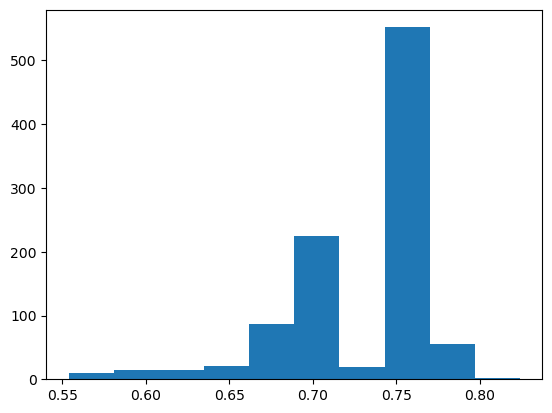

In [17]:
plt.hist(gen_seq_solubility_scores)
min(gen_seq_solubility_scores), max(gen_seq_solubility_scores), np.mean(gen_seq_solubility_scores)

In [33]:
sum(gen_seq_solubility_scores > 0.89)

0

In [34]:
top1000 = gen_seq_solubility_scores[:1000]
top100 = gen_seq_solubility_scores[:100]
top10 = gen_seq_solubility_scores[:10]

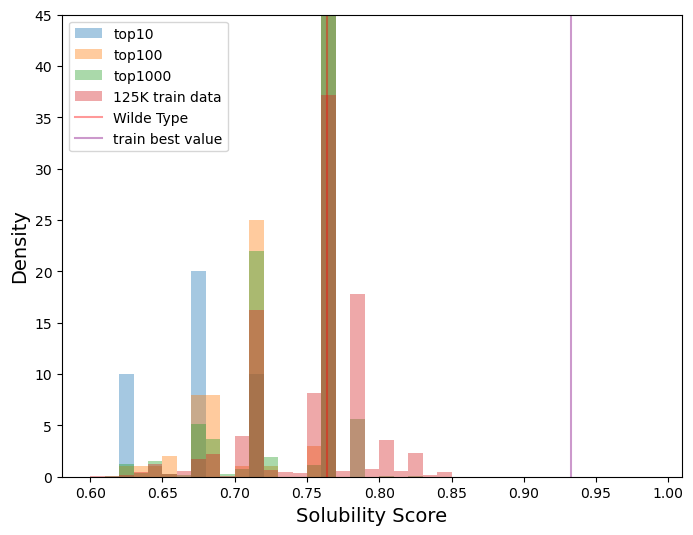

In [44]:
interval = 0.01
density = True
plt.figure(figsize=(8, 6))
plt.hist(top10, density=density, label='top10', bins=np.arange(0.6, 1, interval), alpha=0.4)
plt.hist(top100, density=density, label='top100', bins=np.arange(0.6, 1, interval), alpha=0.4)
plt.hist(top1000, density=density, label='top1000', bins=np.arange(0.6, 1, interval), alpha=0.4)
plt.hist(train_data.solubility, density=density, label='125K train data', bins=np.arange(0.6, 0.9, interval), alpha=0.4)

y_list = np.arange(0, 90)
x_list = [0.764]*len(y_list)
plt.plot(x_list, y_list, label='Wilde Type', color='r', alpha=0.4)
y_list = np.arange(0, 90)
x_list = [y_tau_max]*len(y_list)
plt.plot(x_list, y_list, label='train best value', color='purple', alpha=0.4)

plt.xlabel("Solubility Score", size=14)
plt.ylabel("Density", size=14)
# plt.title(f"Top{topk} Generation Comparison")
plt.legend(loc='upper left')
plt.ylim(0, 45)
plt.savefig('./figures/gen_solubility_dist_topk.png', bbox_inches='tight')
plt.savefig('./figures/gen_solubility_dist_topk.pdf', bbox_inches='tight')

In [292]:
%%time

def hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")
    return sum(s1 != s2 for s1, s2 in zip(seq1, seq2))

gen_seqs = topk_df.MT_seq.tolist()[:1000]
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
hamming_dist_list = [hamming_distance(seq, WT_seq) for seq in gen_seqs]
gen_train_hamming_dist_list = [hamming_distance(row['MT_seq'], WT_seq) for index, row in train_data.iterrows()]

print(f"Hamming distance stats {len(gen_seqs)}")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))
print("std: ", np.std(hamming_dist_list))
len(gen_train_hamming_dist_list)

Hamming distance stats 1000
max:  8
min:  3
median:  6.0
mean:  5.939
std:  1.2850210115013683
CPU times: user 7.87 s, sys: 31.3 ms, total: 7.9 s
Wall time: 7.91 s


250000

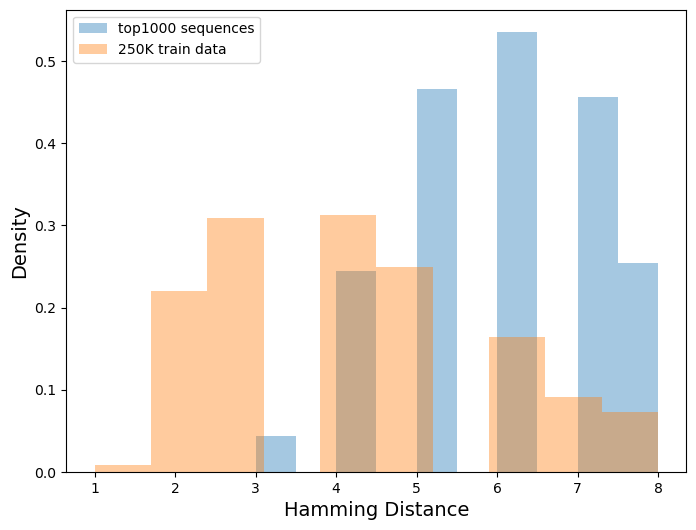

In [293]:
plt.figure(figsize=(8, 6))
# plt.hist(hamming_dist_list, density=True, label='top1000 sequences', bins=[i for i in range(20)], alpha=0.4)
# plt.hist(gen_train_hamming_dist_list, density=True, label='125K train data', bins=[i for i in range(20)], alpha=0.4)
plt.hist(hamming_dist_list, density=True, label='top1000 sequences', alpha=0.4)
plt.hist(gen_train_hamming_dist_list, density=True, label='250K train data', alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
# plt.title("Hamming Distance Distribution")
plt.legend(loc='upper left')
plt.savefig('./figures/solubility_hamming_dist_top1000.png', bbox_inches='tight')
plt.savefig('./figures/solubility_hamming_dist_top1000.pdf', bbox_inches='tight')

In [37]:
train_stats = pd.DataFrame(train_data.solubility).describe()
top1000_stats = pd.DataFrame(top1000).describe()
top100_stats = pd.DataFrame(top100).describe()
top10_stats = pd.DataFrame(top10).describe()
stats_df = pd.concat([train_stats, top1000_stats, top100_stats, top10_stats], axis=1)
stats_df.columns=['Train Data', 'Top1000', 'Top100', 'Top10']
stats_df

,Train Data,Top1000,Top100,Top10
count,250000.000000,1000.000000,100.000000,10.000000
mean,0.751245,0.735913,0.730020,0.726700
std,0.040108,0.043927,0.038811,0.052555
min,0.501000,0.554000,0.624000,0.624000
25%,0.713000,0.713000,0.713000,0.684500
50%,0.764000,0.764000,0.752000,0.764000
75%,0.781000,0.764000,0.764000,0.764000
max,0.933000,0.824000,0.764000,0.764000


In [38]:
y_tau_max = stats_df['Train Data']['max']
y_tau_mean = stats_df['Train Data']['mean']
y_tau_median = np.median(train_data.solubility)
y_tau_WT = 0.764
y_tau_max, y_tau_mean, y_tau_median, y_tau_WT

(0.933, 0.7512453239999999, 0.764, 0.764)

## metrics

In [39]:
def PCI_max(topk_list):
    PCI_a = sum(topk_list > y_tau_max)/len(topk_list)*100
    return f'{PCI_a}%'

def PCI_mean(topk_list):
    PCI_a = sum(topk_list > y_tau_mean)/len(topk_list)*100
    return f'{PCI_a}%'

def PCI_median(topk_list):
    PCI_a = sum(topk_list > y_tau_median)/len(topk_list)*100
    return f'{PCI_a}%'

def PCI_WT(topk_list):
    PCI_a = sum(topk_list > y_tau_WT)/len(topk_list)*100
    return f'{PCI_a}%'

In [40]:
PCI_max(top1000), PCI_max(top100), PCI_max(top10)

('0.0%', '0.0%', '0.0%')

In [41]:
PCI_mean(top1000), PCI_mean(top100), PCI_mean(top10)

('60.9%', '52.0%', '60.0%')

In [42]:
PCI_median(top1000), PCI_median(top100), PCI_median(top10)

('5.800000000000001%', '0.0%', '0.0%')

In [43]:
PCI_WT(top1000), PCI_WT(top100), PCI_WT(top10)

('5.800000000000001%', '0.0%', '0.0%')

In [45]:
# train_stats_list = [y_tau_max, y_tau_mean, y_tau_median, y_tau_WT]
PCI_max_list = [PCI_max(top1000), PCI_max(top100), PCI_max(top10)]
PCI_mean_list = [PCI_mean(top1000), PCI_mean(top100), PCI_mean(top10)]
PCI_median_list = [PCI_median(top1000), PCI_median(top100), PCI_median(top10)]
PCI_WT_list = [PCI_WT(top1000), PCI_WT(top100), PCI_WT(top10)]
PCI_df = pd.DataFrame([PCI_max_list, PCI_mean_list, PCI_median_list, PCI_WT_list], columns=['top1000', 'top100', 'top10'], index=['PCI_max', 'PCI_mean', 'PCI_median', 'PCI_wt'])

In [46]:
PCI_df

,top1000,top100,top10
PCI_max,0.0%,0.0%,0.0%
PCI_mean,60.9%,52.0%,60.0%
PCI_median,5.800000000000001%,0.0%,0.0%
PCI_wt,5.800000000000001%,0.0%,0.0%


In [47]:
stats_df

,Train Data,Top1000,Top100,Top10
count,250000.000000,1000.000000,100.000000,10.000000
mean,0.751245,0.735913,0.730020,0.726700
std,0.040108,0.043927,0.038811,0.052555
min,0.501000,0.554000,0.624000,0.624000
25%,0.713000,0.713000,0.713000,0.684500
50%,0.764000,0.764000,0.752000,0.764000
75%,0.781000,0.764000,0.764000,0.764000
max,0.933000,0.824000,0.764000,0.764000


In [49]:
def hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")
    return sum(s1 != s2 for s1, s2 in zip(seq1, seq2))

def Diversity(gen_seqs):
    distances = []
    for i, seq_i in enumerate(gen_seqs):
        for j, seq_j in enumerate(gen_seqs):
            if i!=j:
                distances.append(hamming_distance(seq_i, seq_j))
    return np.mean(distances)

def worker(args):
    genseq, trainseqs = args
    mindist = np.min([hamming_distance(genseq, trainseq) for trainseq in trainseqs])
    return mindist

def Novelty(genseqs, trainseqs):
    with Pool(cpu_count()) as pool:
        avgdist = list(tqdm(pool.imap(worker, [(genseq, trainseqs) for genseq in genseqs]), total=len(genseqs)))
    return np.mean(avgdist)

In [56]:
gen_seqs = topk_df.MT_seq.tolist()[:10]

In [57]:
Diversity(gen_seqs)

8.733333333333333

In [58]:
Novelty(gen_seqs, train_data.MT_seq)

100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


5.2